In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from openslide import OpenSlide
import h5py
from omegaconf import OmegaConf
from matplotlib import patches
from PIL import Image
import json
from shapely import Polygon
from shapely.plotting import plot_polygon
from shapely.geometry import mapping
from shapely.geometry import box
from shapely.geometry import Polygon
from rtree import index
from collections import Counter
from tqdm import tqdm

In [2]:
conf_preproc = OmegaConf.load("../conf/preproc.yaml")
conf_preproc = conf_preproc["classic_mil_on_embeddings_bag"]["tcga_brca_224_224_patches_jmcs"]

In [ ]:
DATA_ROOT = "<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/WSI/"
DATA_ROOT

In [ ]:
with open("<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/WSI/slide_filenames.txt") as f:
    slides = np.array([line.strip().replace(".svs", "") for line in sorted(f)])

In [5]:
slides.shape, slides[:3]

((3111,),
 array(['TCGA-3C-AAAU-01A-01-TS1.2F52DD63-7476-4E85-B7C6-E06092DB6CC1',
        'TCGA-3C-AALI-01A-01-TSA.7D4960A7-247F-46EE-8D4A-B55170C23EAA',
        'TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4BD-C6B76294C291'],
       dtype='<U69'))

### Number of regions in the TCGA-BRCA cohort

WSIs: 731
patients: 678

### WSI

In [6]:
biopsy_df = pd.read_csv("../02_patch_embeddings/biopsy_df.csv")
labels_df = pd.read_csv("../02_patch_embeddings/labels_df.csv")
biopsy_df.shape, labels_df.shape

((678, 2), (731, 3))

In [7]:
biopsy_df.head(5)

,biopsy_id,stage
0,TCGA-3C-AALI,2
1,TCGA-3C-AALJ,2
2,TCGA-3C-AALK,1
3,TCGA-4H-AAAK,3
4,TCGA-5T-A9QA,2


In [8]:
labels_df.head(5)

,slide_id,biopsy_id,stage
0,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,TCGA-3C-AALI,2
1,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,TCGA-3C-AALI,2
2,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,TCGA-3C-AALJ,2
3,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...,TCGA-3C-AALJ,2
4,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,TCGA-3C-AALK,1


In [9]:
labels_df.biopsy_id.nunique()

678

In [10]:
def load_h5_file(filename):
    with h5py.File(filename, "r") as f:
        coords = f['coords'][()]
        patch_level = f['coords'].attrs['patch_level']
        patch_size = f['coords'].attrs['patch_size']
        return coords, patch_level, patch_size

In [11]:
coords, patch_level, patch_size = load_h5_file(conf_preproc.mask_dir + labels_df.slide_id[0] + ".h5")

In [12]:
coords.shape, patch_level, patch_size

((328, 2), 2, 224)

In [13]:
num_regions = []

for i in tqdm(range(labels_df.shape[0])):

    coords, _, _ = load_h5_file(conf_preproc.mask_dir + labels_df.slide_id[i] + ".h5")

    num_regions.append(coords.shape[0])

num_regions = np.array(num_regions)


00%|██████████| 731/731 [00:02<00:00, 296.62it/s]

In [14]:
print("Number of 224x224 regions:", num_regions.sum())

Number of 224x224 regions: 163782


In [15]:
num_regions.mean()

224.05198358413134

In [16]:
 np.percentile(num_regions, [25, 50, 75])

array([ 92.5, 225. , 334.5])

### Patients

In [17]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [18]:
embeddings, _, _, _ = load_h5_file_biopsy_bag(conf_preproc.uni_finetuned_biopsy_dir_macenko + "TCGA-3C-AALI.h5")

In [19]:
embeddings.shape

(766, 1024)

In [20]:
biopsy_bags = np.sort(np.array( glob.glob( os.path.join(conf_preproc.uni_finetuned_biopsy_dir_macenko, "*.h5")) ))

In [21]:
biopsy_bags.shape

(678,)

In [22]:
num_regions_patients = []

for i in tqdm(range(biopsy_bags.shape[0])):

    embeddings, _, _, _ = load_h5_file_biopsy_bag(conf_preproc.uni_finetuned_biopsy_dir_macenko + os.path.basename(biopsy_bags[i]))

    num_regions_patients.append(embeddings.shape[0])

num_regions_patients = np.array(num_regions_patients)


00%|██████████| 678/678 [00:04<00:00, 140.77it/s]

In [23]:
num_regions_patients.sum()

163782

In [24]:
num_regions_patients.mean()

241.56637168141592

In [25]:
 np.percentile(num_regions_patients, [25, 50, 75])

array([100.5 , 234.5 , 348.75])

### Summary table

In [26]:
# -----------------------------
# ASSUMPTIONS / INPUTS
# - labels_df has columns: ["slide_id", "biopsy_id"]
# - num_regions is a numpy array of length == len(labels_df),
#   containing number of patches (coords.shape[0]) per WSI
# -----------------------------

labels_tcga = labels_df.copy()
assert "slide_id" in labels_tcga.columns, "labels_df must contain slide_id"
assert "biopsy_id" in labels_tcga.columns, "labels_df must contain biopsy_id"
assert len(num_regions) == len(labels_tcga), "num_regions length must match labels_df rows"

# 1) Attach patch counts to each WSI row
labels_tcga["n_patches_wsi"] = np.asarray(num_regions).astype(int)

# 2) Helper to compute median [IQR] and min–max
def median_iqr_minmax(x):
    x = np.asarray(x)
    q1, med, q3 = np.percentile(x, [25, 50, 75])
    return {
        "median": float(med),
        "q1": float(q1),
        "q3": float(q3),
        "min": int(np.min(x)),
        "max": int(np.max(x)),
        "median_iqr_str": f"{med:.0f} [{q1:.0f}, {q3:.0f}]",
        "minmax_str": f"{int(np.min(x))}–{int(np.max(x))}",
    }

# -----------------------------
# A) PATCHES PER WSI
# -----------------------------
wsi_stats = median_iqr_minmax(labels_tcga["n_patches_wsi"].values)

# -----------------------------
# B/C) PATIENT-LEVEL AGGREGATION
# patient_id = biopsy_id
# - patches per patient: sum across patient’s WSIs
# - WSIs per patient: count
# -----------------------------
per_patient_tcga = (
    labels_tcga
    .groupby("biopsy_id", as_index=False)
    .agg(
        n_patches_patient=("n_patches_wsi", "sum"),
        n_wsis=("slide_id", "count"),
    )
)

patient_patch_stats = median_iqr_minmax(per_patient_tcga["n_patches_patient"].values)
wsis_per_patient_stats = median_iqr_minmax(per_patient_tcga["n_wsis"].values)

# -----------------------------
# D) TOTALS
# -----------------------------
total_patches = int(labels_tcga["n_patches_wsi"].sum())
n_wsis = int(labels_tcga["slide_id"].nunique())
n_patients = int(labels_tcga["biopsy_id"].nunique())

# 3) Final 1-row cohort summary table (TCGA-BRCA)
summary_tcga_brca = pd.DataFrame([{
    "Cohort": "TCGA-BRCA",
    "Patients (n)": n_patients,
    "WSIs (n)": n_wsis,
    "WSIs/patient, median [IQR]": wsis_per_patient_stats["median_iqr_str"],
    "WSIs/patient, min–max": wsis_per_patient_stats["minmax_str"],
    "Patches/WSI, median [IQR]": wsi_stats["median_iqr_str"],
    "Patches/WSI, min–max": wsi_stats["minmax_str"],
    "Patches/patient, median [IQR]": patient_patch_stats["median_iqr_str"],
    "Patches/patient, min–max": patient_patch_stats["minmax_str"],
    "Total patches (2.5x)": total_patches,
}])

summary_tcga_brca

,Cohort,Patients (n),WSIs (n),"WSIs/patient, median [IQR]","WSIs/patient, min–max","Patches/WSI, median [IQR]","Patches/WSI, min–max","Patches/patient, median [IQR]","Patches/patient, min–max",Total patches (2.5x)
0,TCGA-BRCA,678,731,"1 [1, 1]",1–3,"225 [92, 334]",1–628,"234 [100, 349]",1–929,163782


In [27]:
summary_tcga_brca.to_csv("summary_tcga_brca.csv", index=False)

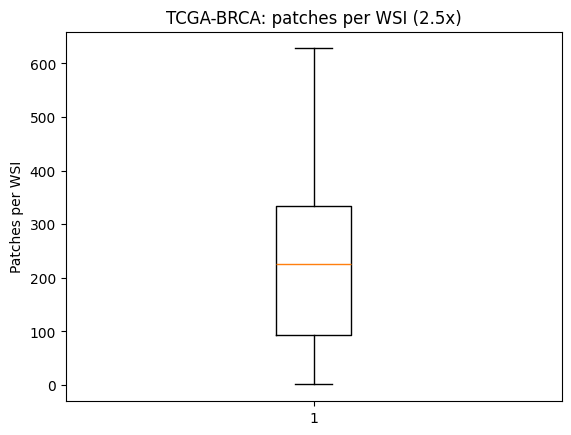

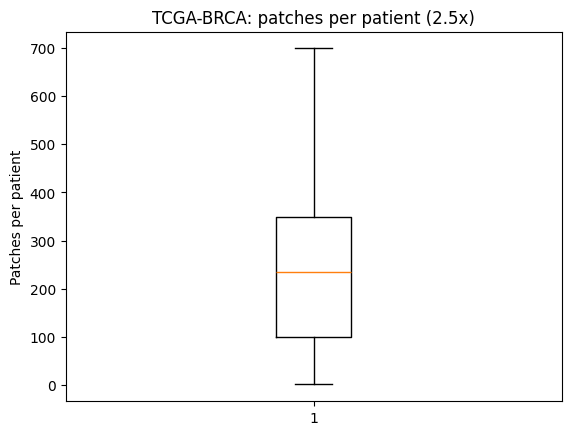

In [28]:
plt.figure()
plt.boxplot(labels_tcga["n_patches_wsi"].values, showfliers=False)
plt.ylabel("Patches per WSI")
plt.title("TCGA-BRCA: patches per WSI (2.5x)")
plt.show()

plt.figure()
plt.boxplot(per_patient_tcga["n_patches_patient"].values, showfliers=False)
plt.ylabel("Patches per patient")
plt.title("TCGA-BRCA: patches per patient (2.5x)")
plt.show()
